In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import math
from matplotlib.colors import LogNorm

import math
from astropy import units
from astropy.wcs import WCS
from scipy.fftpack import fft2, fftshift
from scipy.fft import fft, fftfreq
from scipy.ndimage import map_coordinates
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization import make_lupton_rgb
from skimage.feature import peak_local_max
from astropy.visualization import simple_norm
from scipy.spatial import cKDTree
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d

from matplotlib.patches import Circle
from astropy.visualization.wcsaxes import SphericalCircle
from scipy.signal import resample
from scipy.signal import find_peaks
from matplotlib.patches import Wedge
from reproject import reproject_interp
from photutils.centroids import centroid_2dg
from scipy.ndimage import shift
from matplotlib.cm import get_cmap

from turbustat.statistics import PowerSpectrum
import emcee

from scipy.ndimage import gaussian_filter
import webbpsf
from scipy.ndimage import zoom
from scipy.signal import convolve2d

arcsec2_over_sr = 4.254791e10
base_dir = "/export/home/extragal/francesco.chititegli/JWST/TESI2/"
gallery_dir = '/export/home/extragal/francesco.chititegli/GALLERY/'


# Support function

In [2]:
def judge_distance(filename):
    if filename.startswith("IC5332"):
        distance = 9.01e6; name = "IC5332"; center = [448, 302]
        return distance, name, center
    elif filename.startswith("NGC0628"):
        distance = 9.84e6; name = "NGC0628"; center = [713, 706]
        return distance, name, center
    elif filename.startswith("NGC1087"):
        distance = 15.85e6; name = "NGC1087"; center = [448, 304]
        return distance, name, center
    elif filename.startswith("NGC1300"):
        distance = 18.99e6; name = "NGC1300"; center = [450, 739]
        return distance, name, center
    elif filename.startswith("NGC1365"):
        distance = 19.57e6; name = "NGC1365"; center = [450, 739]
        return distance, name, center
    elif filename.startswith("NGC1385"):
        distance = 17.22e6; name = "NGC1385"; center = [448, 305]
        return distance, name, center
    elif filename.startswith("NGC1433"):
        distance = 8.3e6; name = "NGC1433"; center = [457, 740]
        return distance, name, center
    elif filename.startswith("NGC1512"):
        distance = 17.93e6; name = "NGC1512"; center = [465, 460]
        return distance, name, center
    elif filename.startswith("NGC1566"):
        distance = 18e6; name = "NGC1566"; center = [450, 449]
        return distance, name, center
    elif filename.startswith("NGC1672"):
        distance = 19.4e6; name = "NGC1672"; center = [325, 617]
        return distance, name, center
    elif filename.startswith("NGC2835"):
        distance = 12.22e6; name = "NGC2835"; center = [449, 450]
        return distance, name, center
    elif filename.startswith("NGC3351"):
        distance = 10e6; name = "NGC3351"; center = [440, 455]
        return distance, name, center
    else:
        raise FileNotFoundError('The file ' + str(filename) + ' has no distance!')


# Load Ha images

In [46]:
images_Ha = []
errors_Ha = []
wcs_Ha = []
names = []
centers = []
pixel_scales_Ha = []
distances = []

for filename in os.listdir(base_dir):
    if filename.endswith("asec.fits"):
        filepath = os.path.join(base_dir, filename)
        with fits.open(filepath) as hdul:
            header_Ha = hdul[30].header
            image_Ha = hdul[30].data
            image_Ha_err = hdul[31].data
        wcs = WCS(header_Ha)
        distance, name, center = judge_distance(filename)
        
        arcsecond_to_pc = distance / 206265
        pixel_scale_Ha = np.abs(wcs.wcs.cd[1][1]) * 3600
        arcsecond_length_in_pixels_Ha = 1 / pixel_scale_Ha
        print(str(name) + r' Starting Unit: ' + str(header_Ha.get("BUNIT", "Unknown Unit")))
        image_Ha = image_Ha * 1e-3 / (pixel_scale_Ha ** 2)
        image_Ha_err = image_Ha_err * 1e-3 / (pixel_scale_Ha ** 2)

        images_Ha.append(image_Ha)
        errors_Ha.append(image_Ha_err)
        wcs_Ha.append(wcs)
        names.append(name)
        centers.append(center)
        pixel_scales_Ha.append(pixel_scale_Ha)
        distances.append(distance)
        print(r'Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: ' + str(np.nanmean(image_Ha)) + 'with error: ' + str(np.nanmean(image_Ha_err)))


NGC1300 Starting Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: 4.309893628608914with error: 0.08427206796587842
NGC0628 Starting Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: 15.73964899030222with error: 0.19371360344383512
NGC1087 Starting Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: 20.46828160691584with error: 0.12023705698544163
IC5332 Starting Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: 5.523717571252704with error: 0.13070023857968446
NGC1365 Starting Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: 18.425435830087235with error: 0.08276068398957134
NGC1385 Starting Unit: 1e-20erg.s**(-1).cm**(-2).spaxel**(-1)
Ha mean [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]: 29.00490686586241with error: 

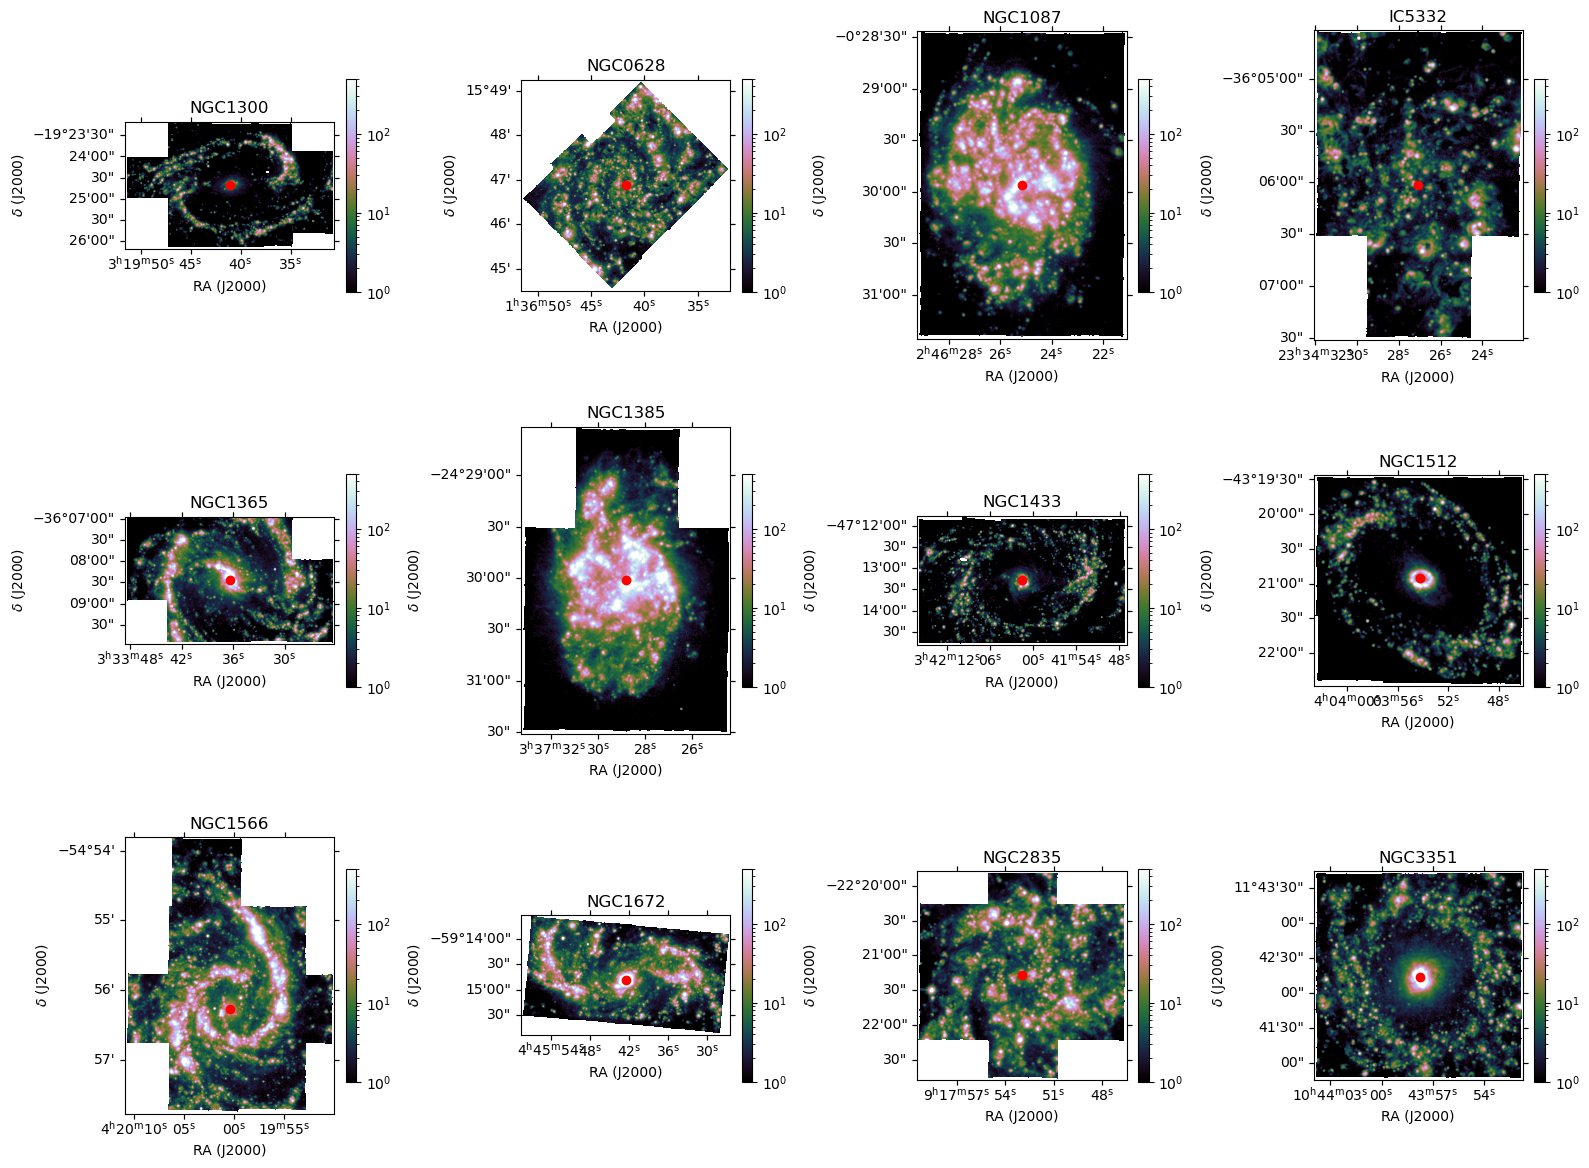

In [74]:
fig = plt.figure(figsize=(16, 12))
for i in range(len(images_Ha)):
    ax = fig.add_subplot(3, 4, i + 1, projection=wcs_Ha[i])
    im = ax.imshow(images_Ha[i], origin='lower', cmap='cubehelix', norm=LogNorm(vmin=1e0, vmax=5e2))
    plt.colorbar(im, ax=ax, fraction=0.046)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel(r'$\delta$ (J2000)')
    ax.set_title(names[i])
    ax.scatter(centers[i][1], centers[i][0],color='red')
plt.tight_layout()
plt.show()

# Load IR images

In [50]:
raw_images_IR = []
raw_wcs_IR = []
raw_names_IR = []
pixel_scales_IR = []

for filename in os.listdir(base_dir):
    if filename.endswith("_img.fits"):
        filepath = os.path.join(base_dir, filename)
        with fits.open(filepath) as hdul:
            header_IR = hdul[1].header
            image_IR = hdul[1].data
        wcs = WCS(header_IR)
        distance, name, center = judge_distance(filename.removeprefix('hlsp_phangs-jwst_jwst_miri_').upper())
        pixel_scale_IR = np.abs(wcs.wcs.cdelt[0]) * 3600
        image_IR[image_IR == 0] = np.nan

        raw_images_IR.append(image_IR)
        raw_wcs_IR.append(wcs)
        raw_names_IR.append(name)
        pixel_scales_IR.append(pixel_scale_IR)
        print(str(name) + r' Starting Unit: ' + str(header_IR.get("BUNIT", "Unknown Unit")))
        print(r'IR mean [MJy/sr]: ' + str(np.nanmean(image_IR)))
idx_map = {str(name): i for i, name in enumerate(raw_names_IR)}
pre_images_IR = [raw_images_IR[idx_map[str(name)]] for name in names]
pre_wcs_IR = [raw_wcs_IR[idx_map[str(name)]] for name in names]


NGC1300 Starting Unit: MJy/sr
IR mean [MJy/sr]: 0.5151924
NGC0628 Starting Unit: MJy/sr
IR mean [MJy/sr]: 1.3416706
IC5332 Starting Unit: MJy/sr
IR mean [MJy/sr]: 0.24272978
NGC1087 Starting Unit: MJy/sr
IR mean [MJy/sr]: 1.8924209
NGC1365 Starting Unit: MJy/sr
IR mean [MJy/sr]: 6.3967876
NGC1385 Starting Unit: MJy/sr
IR mean [MJy/sr]: 4.003398
NGC1433 Starting Unit: MJy/sr
IR mean [MJy/sr]: 0.4549702
NGC1512 Starting Unit: MJy/sr
IR mean [MJy/sr]: 0.41123343
NGC1566 Starting Unit: MJy/sr
IR mean [MJy/sr]: 2.2104409
NGC1672 Starting Unit: MJy/sr
IR mean [MJy/sr]: 5.934258
NGC2835 Starting Unit: MJy/sr
IR mean [MJy/sr]: 0.83315116
NGC3351 Starting Unit: MJy/sr
IR mean [MJy/sr]: 1.9836591


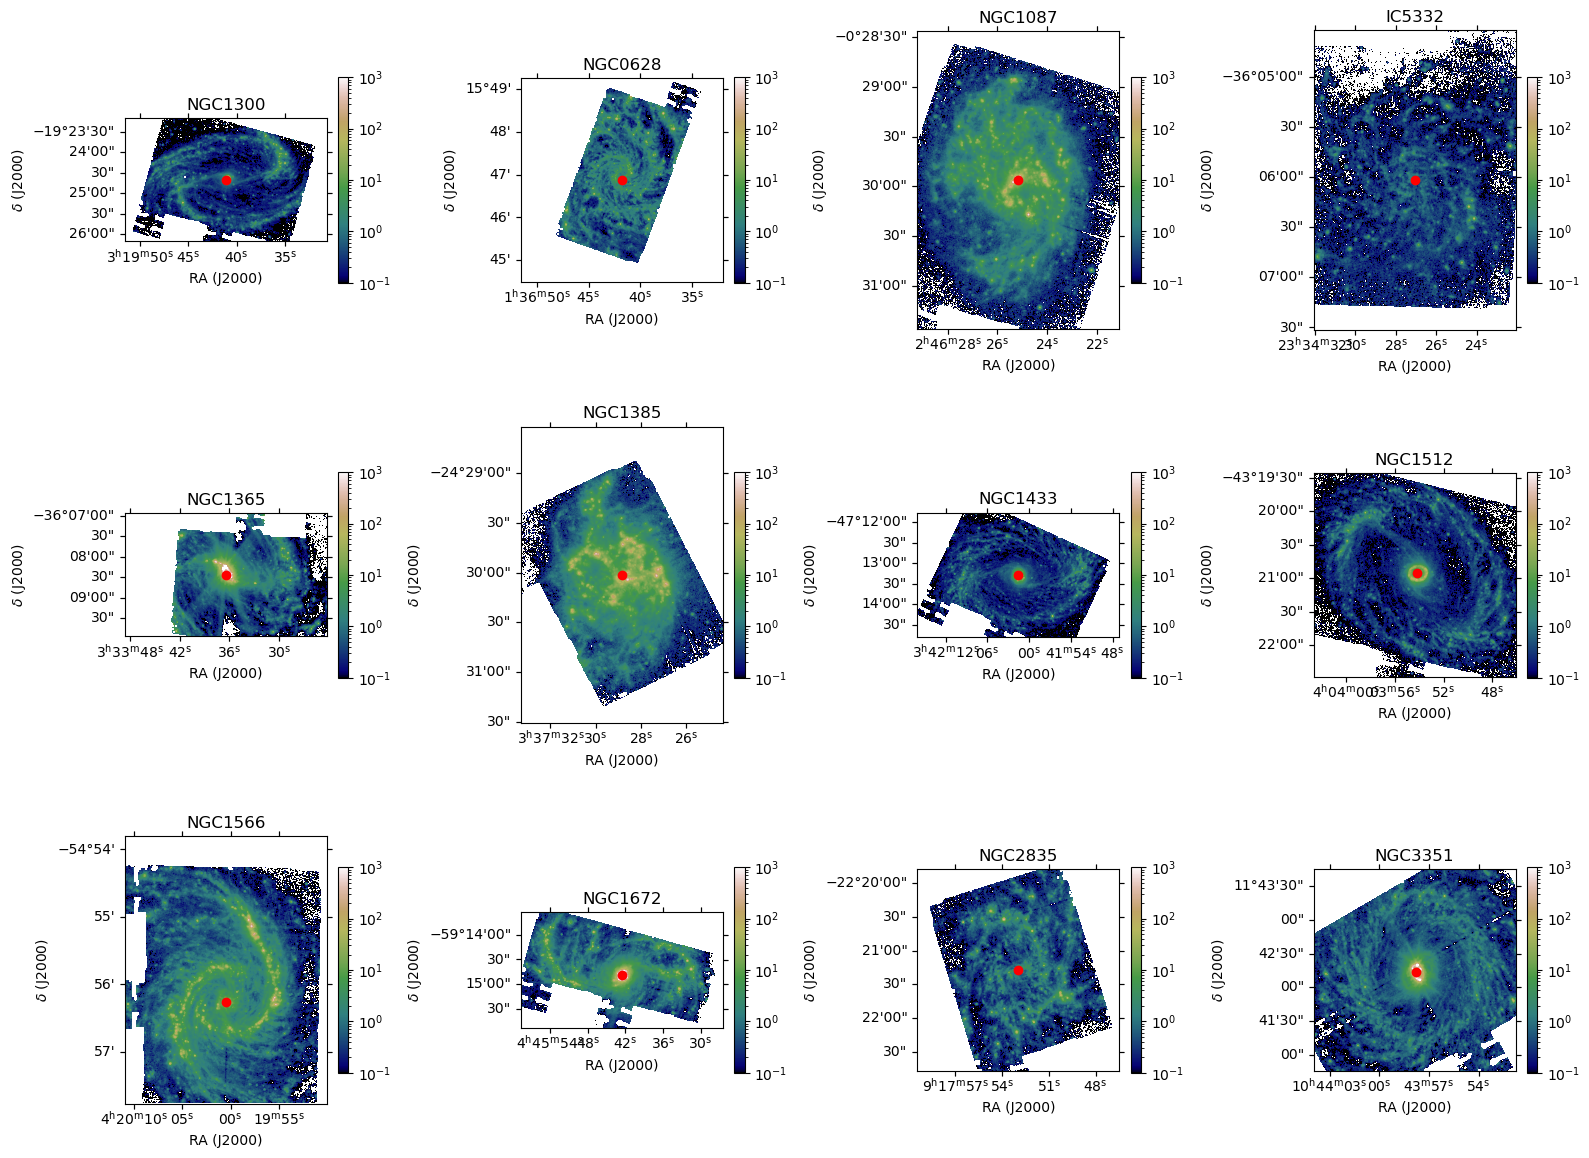

In [54]:
images_IR = []

for i in range(len(images_Ha)):
    array_IR_reprojected, _ = reproject_interp((pre_images_IR[i], pre_wcs_IR[i]), wcs_Ha[i], shape_out=images_Ha[i].shape)
    images_IR.append(array_IR_reprojected)

fig = plt.figure(figsize=(16, 12))
for i in range(len(images_IR)):
    ax = fig.add_subplot(3, 4, i + 1, projection=wcs_Ha[i])
    im = ax.imshow(images_IR[i], origin='lower', cmap='gist_earth', norm=LogNorm(vmin=1e-1, vmax=1e3))
    plt.colorbar(im, ax=ax, fraction=0.046)
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel(r'$\delta$ (J2000)')
    ax.set_title(names[i])
    ax.scatter(centers[i][1], centers[i][0],color='red')
plt.tight_layout()
plt.show()

# Radial trends

In [81]:
thresholds_Ha = []
thresholds_IR = []
print('Ha thresholds')
for i, img in enumerate(images_Ha):
    data = img.flatten()
    data_pos = data[data > 0]
    bins = np.logspace(np.log10(np.nanmin(data_pos)), np.log10(np.nanmax(data_pos)), 50)
    counts, bins_edges = np.histogram(data_pos, bins=bins)
    mode_bin_index = np.argmax(counts)
    mode = bins_edges[mode_bin_index]
    left_data = data_pos[data_pos < mode]
    cut = np.percentile(left_data, 5)
    thresholds_Ha.append(cut)
    print(f"{i}: Cut 5% = {cut:.4e}")
print()
print('IR thresholds')
for i, img in enumerate(images_IR):
    data = img.flatten()
    data_pos = data[data > 0]
    bins = np.logspace(np.log10(np.nanmin(data_pos)), np.log10(np.nanmax(data_pos)), 50)
    counts, bins_edges = np.histogram(data_pos, bins=bins)
    mode_bin_index = np.argmax(counts)
    mode = bins_edges[mode_bin_index]
    left_data = data_pos[data_pos < mode]
    cut = np.percentile(left_data, 5)
    thresholds_IR.append(cut)
    print(f"{i}: Cut 5% = {cut:.4e}")
thresholds_Ha = np.array(thresholds_Ha)
thresholds_IR = np.array(thresholds_IR)

Ha thresholds
0: Cut 5% = 1.0751e-01
1: Cut 5% = 1.0657e+00
2: Cut 5% = 9.4640e-02
3: Cut 5% = 3.5119e-01
4: Cut 5% = 3.4706e-01
5: Cut 5% = 1.2219e-01
6: Cut 5% = 1.3339e-01
7: Cut 5% = 6.3185e-02
8: Cut 5% = 5.5083e-01
9: Cut 5% = 6.2684e-01
10: Cut 5% = 7.3278e-01
11: Cut 5% = 4.9847e-01

IR thresholds
0: Cut 5% = 2.3516e-02
1: Cut 5% = 5.1335e-02
2: Cut 5% = 2.4999e-02
3: Cut 5% = 2.1913e-02
4: Cut 5% = 2.6435e-02
5: Cut 5% = 3.6923e-02
6: Cut 5% = 2.2091e-02
7: Cut 5% = 2.0431e-02
8: Cut 5% = 4.8900e-02
9: Cut 5% = 5.1197e-02
10: Cut 5% = 3.0975e-02
11: Cut 5% = 4.5496e-02


In [82]:
Ha_TIGRESS = 1e17 * np.array([3.2657041343781756e-17,
 8.195016805893936e-17,
 6.326041772721127e-17,
 7.320631317737327e-17,
 3.597288174056798e-17,
 5.1419477517176165e-17,
 1.570496905455835e-17,
 5.0277106075661596e-17,
 2.8756643500847415e-17,
 1.3566977999168938e-16])
IR_TIGRESS = np.array([6.516483018002559,
 25.007222974076246,
 23.879573213076732,
 27.372374473555034,
 4.953901255789962,
 13.945852893045283,
 4.625424215786669,
 15.430711561293721,
 8.02554020240528,
 38.03363199870648])
radii_TIGRESS = [8000] * 10

radial_trends = []

thickness_pc = 50
for j in range(len(images_Ha)):
    print(names[j])
    arcsecond_to_pc = distances[j] / 206265
    pixel_scale_pc = pixel_scales_Ha[j] * arcsecond_to_pc
    thickness_pix = thickness_pc / pixel_scale_pc
    
    ny, nx = images_Ha[j].shape
    Y, X = np.indices((ny, nx))
    r = np.sqrt((X - centers_Ha[j][1])**2 + (Y - centers_Ha[j][0])**2)
    r_pc = r * pixel_scale_pc
    r_max_pc = r_pc.max()
    n_bins = int(r_max_pc // thickness_pc)

    radii = []
    means_Ha = []
    means_IR = []

    for i in range(n_bins):
        r_in = i * thickness_pc
        r_out = (i + 1) * thickness_pc
        radial_mask = (r_pc >= r_in) & (r_pc < r_out)
        ha_mask = images_Ha[j] > thresholds_Ha[j]
        ir_mask = images_IR[j] > thresholds_IR[j]
        mask_Ha = radial_mask & ha_mask
        mask_IR = radial_mask & ir_mask
        masked_Ha = np.where(ha_mask, images_Ha[j], np.nan)
        masked_IR = np.where(ir_mask, images_IR[j], np.nan)
        mean_Ha = np.nanmean(masked_Ha)
        mean_IR = np.nanmean(masked_IR)
    
        radii.append((r_in + r_out) / 2)
        means_Ha.append(mean_Ha)
        means_IR.append(mean_IR)
    radii = np.array(radii)
    means_Ha = np.array(means_Ha)
    means_IR = np.array(means_IR)

    radial_trends.append(np.vstack([radii, means_Ha, means_IR]))

radii_common = np.linspace(0, np.max([rt[0].max() for rt in radial_trends]), 100)

interpolated_means_Ha = []
for rt in radial_trends:
    r, y = rt[0], rt[1]
    mask = ~np.isnan(y)
    f = interp1d(r[mask], y[mask], bounds_error=False, fill_value=np.nan)
    interpolated_means_Ha.append(f(radii_common))
interpolated_means_Ha = np.array(interpolated_means_Ha)
mean_radial_trend_Ha = np.array([np.nanmean(np.where(col > 0, col, np.nan)) for col in interpolated_means_Ha.T])
minval_radial_trend_Ha = np.array([np.nanmin(col[col > 0]) if np.any(col > 0) else np.nan for col in interpolated_means_Ha.T])
maxval_radial_trend_Ha = np.nanmax(interpolated_means_Ha, axis=0)

interpolated_means_IR = []
for rt in radial_trends:
    r, y = rt[0], rt[2]
    mask = ~np.isnan(y)
    f = interp1d(r[mask], y[mask], bounds_error=False, fill_value=np.nan)
    interpolated_means_IR.append(f(radii_common))
interpolated_means_IR = np.array(interpolated_means_IR)
mean_radial_trend_IR = np.array([np.nanmean(np.where(col > 0, col, np.nan)) for col in interpolated_means_IR.T])
minval_radial_trend_IR = np.array([np.nanmin(col[col > 0]) if np.any(col > 0) else np.nan for col in interpolated_means_IR.T])
maxval_radial_trend_IR = np.nanmax(interpolated_means_IR, axis=0)


NGC1300
NGC0628
NGC1087
IC5332
NGC1365
NGC1385
NGC1433
NGC1512
NGC1566
NGC1672
NGC2835
NGC3351


/tmp/ipykernel_2687254/3018090870.py:74: RuntimeWarning: Mean of empty slice
  mean_radial_trend_Ha = np.array([np.nanmean(np.where(col > 0, col, np.nan)) for col in interpolated_means_Ha.T])
/tmp/ipykernel_2687254/3018090870.py:76: RuntimeWarning: All-NaN slice encountered
  maxval_radial_trend_Ha = np.nanmax(interpolated_means_Ha, axis=0)
/tmp/ipykernel_2687254/3018090870.py:85: RuntimeWarning: Mean of empty slice
  mean_radial_trend_IR = np.array([np.nanmean(np.where(col > 0, col, np.nan)) for col in interpolated_means_IR.T])
/tmp/ipykernel_2687254/3018090870.py:87: RuntimeWarning: All-NaN slice encountered
  maxval_radial_trend_IR = np.nanmax(interpolated_means_IR, axis=0)


/tmp/ipykernel_2687254/3843571381.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


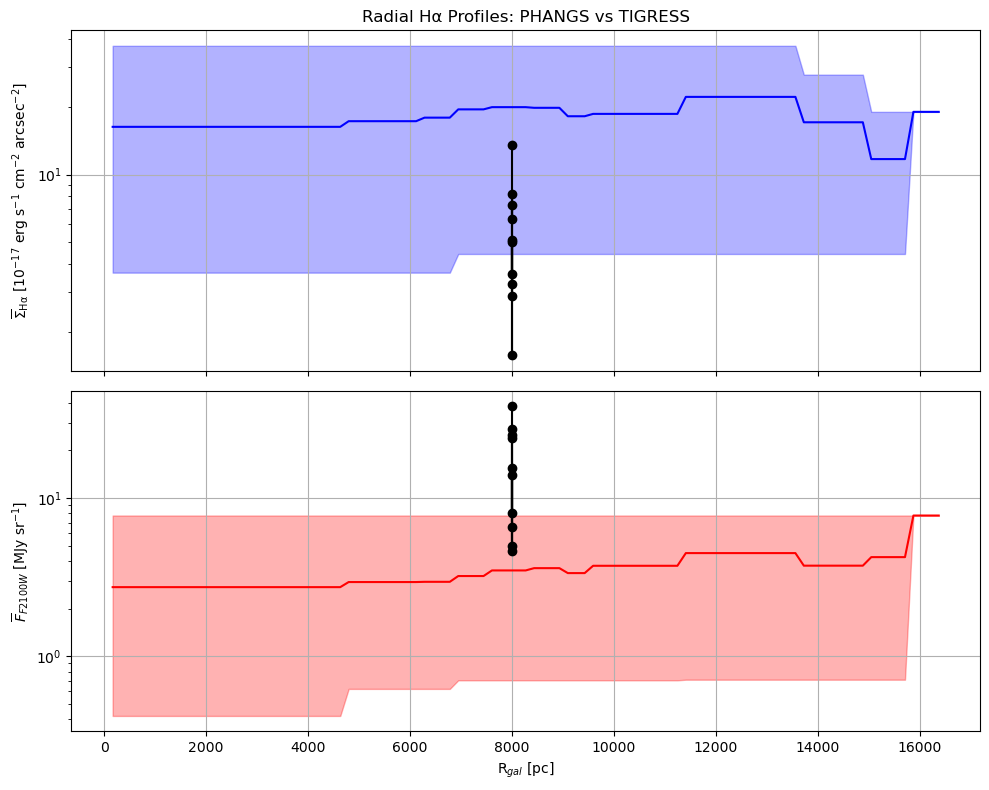

In [83]:
cmap = get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(radial_trends_Ha)))
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 8), sharex=True)

ax1.plot(radii_common, mean_radial_trend_Ha, color='blue', label=r'H$\alpha$')
ax1.fill_between(radii_common, minval_radial_trend_Ha, maxval_radial_trend_Ha, alpha=0.3, color='blue')
ax1.plot(radii_TIGRESS, Ha_TIGRESS, marker='o', color='black', label='TIGRESS')
'''
for i in range(len(radial_trends_Ha)):
    ax1.plot(radial_trends_Ha[i][0], radial_trends_Ha[i][1], color=colors[i], alpha=0.5)
'''
ax1.set_ylabel(r'$\overline{\Sigma}_{\mathrm{H\alpha}}$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]')
ax1.set_title('Radial Hα Profiles: PHANGS vs TIGRESS')
ax1.set_yscale('log')
ax1.grid(True)
#ax1.legend()

ax2.plot(radii_common, mean_radial_trend_IR, color='red', label='IR')
ax2.fill_between(radii_common, minval_radial_trend_IR, maxval_radial_trend_IR, alpha=0.3, color='red')
ax2.plot(radii_TIGRESS, IR_TIGRESS, marker='o', color='black', label='TIGRESS')
ax2.set_xlabel(r'R$_{gal}$ [pc]')
ax2.set_ylabel(r'$\overline{F}_{F2100W}$ [MJy sr$^{-1}$]')
ax2.set_yscale('log')
ax2.grid(True)
#ax2.legend()
plt.tight_layout()
plt.savefig(f"{gallery_dir}PHANGS__GalRadial.jpeg", format='jpeg', dpi=100)
plt.show()

# Leroy 2023

In [13]:
Ha_ref = []
er_ref = []
IR_ref = []

wcs_ref = wcs_Ha
shape_ref = [img.shape for img in images_Ha]
for i in range(len(pre_images_IR)):
    image_IR_reprojected, footprint_IR = reproject_interp((pre_images_IR[i], pre_wcs_IR[i]), output_projection=wcs_ref[i], shape_out=shape_ref[i])
    combined_nan_mask = (np.isnan(images_Ha[i]) | np.isnan(image_IR_reprojected) | (image_IR_reprojected == 0))
    
    image_Ha_new = images_Ha[i].copy()
    error_Ha_new = errors_Ha[i].copy()
    image_IR_new = image_IR_reprojected.copy()
    
    image_Ha_new[combined_nan_mask] = np.nan
    error_Ha_new[combined_nan_mask] = np.nan
    image_IR_new[combined_nan_mask] = np.nan

    Ha_ref.append(image_Ha_new)
    er_ref.append(error_Ha_new)
    IR_ref.append(image_IR_new)
    print(str(names[i]) + ' new Shapes. Ha: ' + str(images_Ha[i].shape) + ' IR: ' + str(image_IR_reprojected.shape))
    

NGC1300 new Shapes. Ha: (900, 1478) IR: (900, 1478)
NGC0628 new Shapes. Ha: (1426, 1412) IR: (1426, 1412)
NGC1087 new Shapes. Ha: (897, 609) IR: (897, 609)
IC5332 new Shapes. Ha: (897, 605) IR: (897, 605)
NGC1365 new Shapes. Ha: (900, 1478) IR: (900, 1478)
NGC1385 new Shapes. Ha: (896, 610) IR: (896, 610)
NGC1433 new Shapes. Ha: (915, 1480) IR: (915, 1480)
NGC1512 new Shapes. Ha: (910, 903) IR: (910, 903)
NGC1566 new Shapes. Ha: (1187, 898) IR: (1187, 898)
NGC1672 new Shapes. Ha: (711, 1235) IR: (711, 1235)
NGC2835 new Shapes. Ha: (899, 900) IR: (899, 900)
NGC3351 new Shapes. Ha: (896, 897) IR: (896, 897)


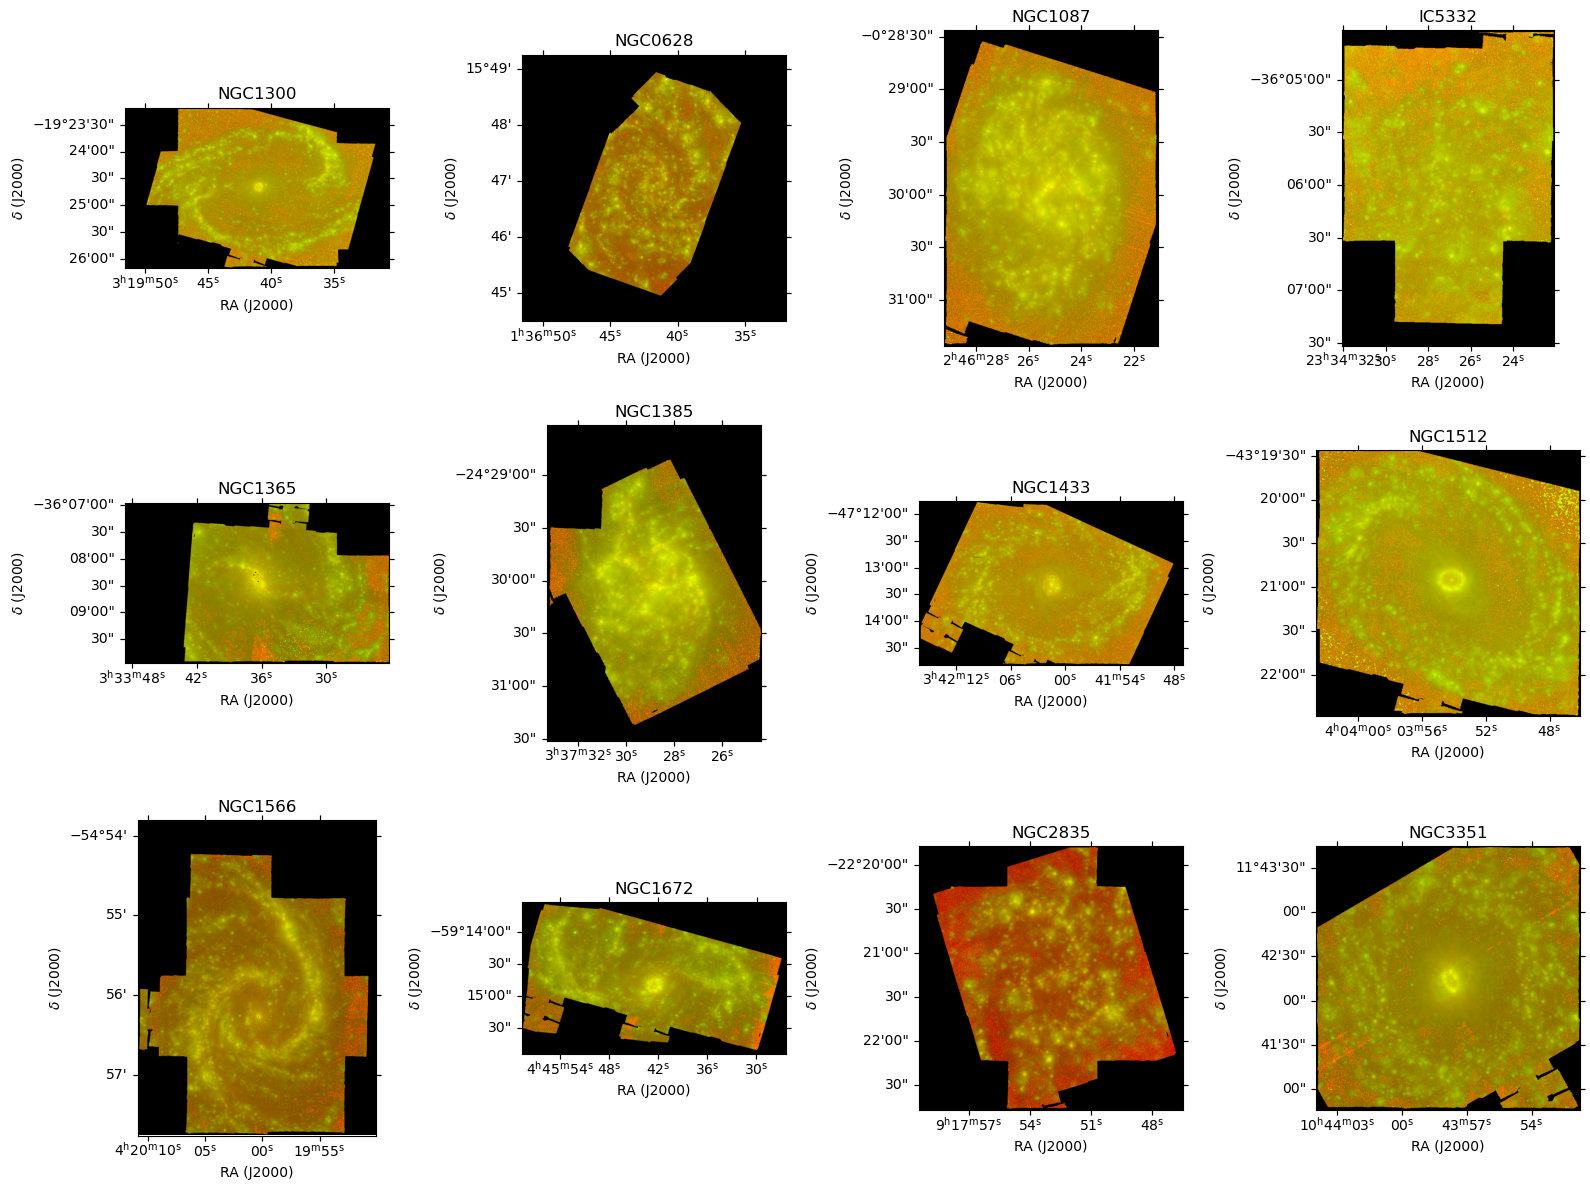

In [131]:
fig = plt.figure(figsize=(16, 12))
for i in range(len(images_Ha)):
    ax = fig.add_subplot(3, 4, i + 1, projection=wcs_ref[i])
    ha_norm = LogNorm(vmin=np.nanmin(Ha_ref[i][Ha_ref[i] > 0]), vmax=np.nanmax(Ha_ref[i]))
    ir_norm = LogNorm(vmin=np.nanmin(IR_ref[i][IR_ref[i] > 0]), vmax=np.nanmax(IR_ref[i]))
    Ha_scaled = ha_norm(Ha_ref[i])
    IR_scaled = ir_norm(IR_ref[i])

    RGB = np.zeros((*Ha_scaled.shape, 3))
    RGB[..., 0] = np.nan_to_num(IR_scaled)
    RGB[..., 1] = np.nan_to_num(Ha_scaled)
    RGB = np.clip(RGB, 0, 1)

    ax.imshow(RGB, origin='lower')
    ax.set_xlabel('RA (J2000)')
    ax.set_ylabel(r'$\delta$ (J2000)')
    ax.set_title(names[i])
plt.tight_layout()
plt.show()
